In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/02/8c/dc970bc00867fe290e8c8a7b

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [6]:
# Specify the absolute path to the dataset
dataset_path = r"C:\Users\HP\Desktop\training.1600000.processed.noemoticon.csv"

# Print information about the dataset
print("Open file:", dataset_path)

# Read the dataset into a DataFrame
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)


Open file: C:\Users\HP\Desktop\training.1600000.processed.noemoticon.csv


In [7]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 250 ms
Wall time: 523 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

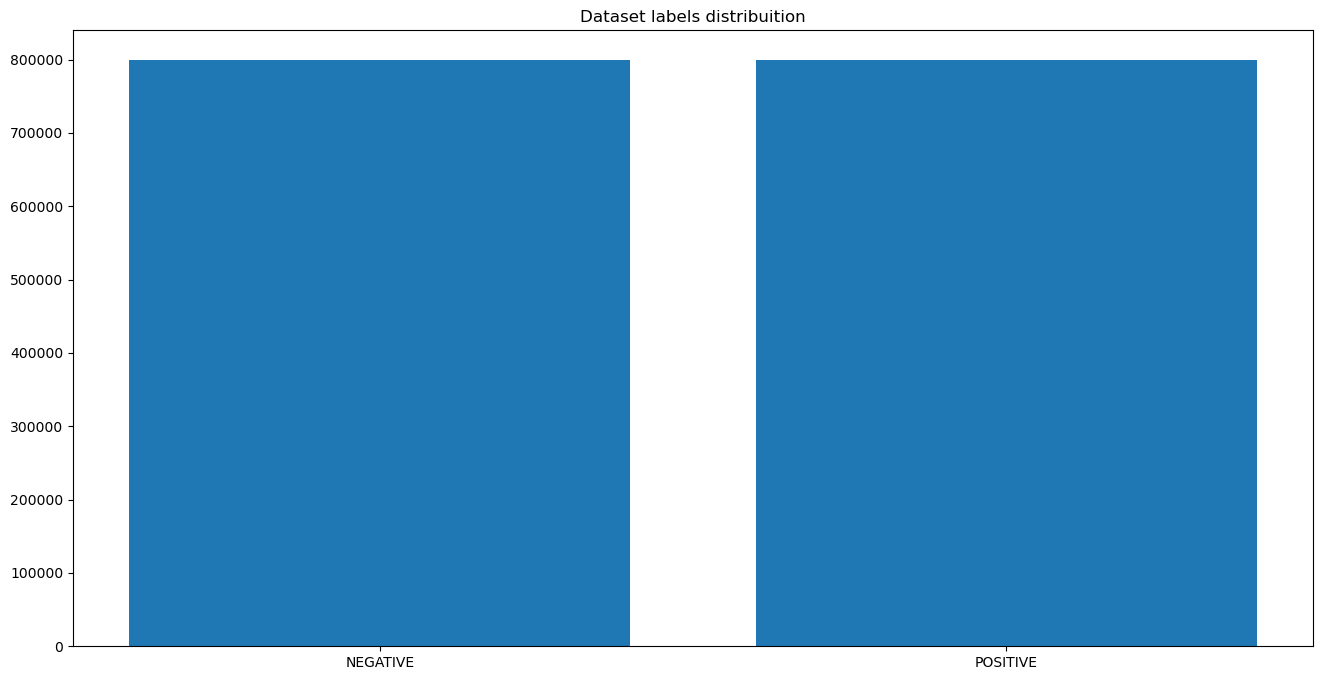

In [11]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [12]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 34.4 s
Wall time: 1min 11s


In [15]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [16]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 3.02 s
Wall time: 4.76 s


In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


2023-12-08 22:34:24,585 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2023-12-08T22:34:24.585440', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}


In [19]:
w2v_model.build_vocab(documents)

2023-12-08 22:34:43,953 : INFO : collecting all words and their counts
2023-12-08 22:34:43,953 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-12-08 22:34:43,975 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2023-12-08 22:34:43,998 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2023-12-08 22:34:44,028 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2023-12-08 22:34:44,059 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2023-12-08 22:34:44,091 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2023-12-08 22:34:44,109 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2023-12-08 22:34:44,127 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2023-12-08 22:34:44,145 : INFO : PROGRESS: at s

2023-12-08 22:34:45,566 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2023-12-08 22:34:45,588 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2023-12-08 22:34:45,606 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2023-12-08 22:34:45,625 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2023-12-08 22:34:45,643 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2023-12-08 22:34:45,661 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2023-12-08 22:34:45,678 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2023-12-08 22:34:45,698 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2023-12-08 22:34:45,715 : INFO : PROGRESS: at sentence #800000, processed 577088

In [24]:
# Change the following line in Cell-20
# words = w2v_model.wv.vocab.keys()

# To the following, using key_to_index
words = list(w2v_model.wv.key_to_index.keys())

# Rest of the code remains unchanged
vocab_size = len(words)
print("Vocab size", vocab_size)


Vocab size 30369


In [25]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-12-08 22:40:48,961 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2023-12-08T22:40:48.961815', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'train'}
2023-12-08 22:40:49,996 : INFO : EPOCH 0 - PROGRESS: at 17.03% examples, 1392147 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:40:50,993 : INFO : EPOCH 0 - PROGRESS: at 35.97% examples, 1474073 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:40:51,993 : INFO : EPOCH 0 - PROGRESS: at 55.64% examples, 1522455 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:40:53,007 : INFO : EPOCH 0 - PROGRESS: at 73.94% examples, 1514891 words/s, in_qsize 15, out_qsize 1
2023-12-08 22:40:54,006 : INFO : EPOCH 0 - PROGRESS: at 94.58% examples, 1550022 words/s, in_qsize 16, ou

2023-12-08 22:41:47,420 : INFO : EPOCH 11 - PROGRESS: at 18.76% examples, 1526438 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:41:48,422 : INFO : EPOCH 11 - PROGRESS: at 39.00% examples, 1593816 words/s, in_qsize 14, out_qsize 1
2023-12-08 22:41:49,423 : INFO : EPOCH 11 - PROGRESS: at 58.58% examples, 1599881 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:41:50,424 : INFO : EPOCH 11 - PROGRESS: at 78.62% examples, 1611487 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:41:51,425 : INFO : EPOCH 11 - PROGRESS: at 98.69% examples, 1618382 words/s, in_qsize 13, out_qsize 0
2023-12-08 22:41:51,478 : INFO : EPOCH 11: training on 9227204 raw words (8222676 effective words) took 5.1s, 1622541 effective words/s
2023-12-08 22:41:52,503 : INFO : EPOCH 12 - PROGRESS: at 17.89% examples, 1465577 words/s, in_qsize 16, out_qsize 1
2023-12-08 22:41:53,502 : INFO : EPOCH 12 - PROGRESS: at 35.86% examples, 1472419 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:41:54,503 : INFO : EPOCH 12 - PROGRESS

2023-12-08 22:42:48,661 : INFO : EPOCH 22 - PROGRESS: at 97.18% examples, 1591776 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:42:48,778 : INFO : EPOCH 22: training on 9227204 raw words (8222712 effective words) took 5.1s, 1600519 effective words/s
2023-12-08 22:42:49,797 : INFO : EPOCH 23 - PROGRESS: at 17.89% examples, 1467980 words/s, in_qsize 16, out_qsize 0
2023-12-08 22:42:50,800 : INFO : EPOCH 23 - PROGRESS: at 37.16% examples, 1524371 words/s, in_qsize 14, out_qsize 1
2023-12-08 22:42:51,805 : INFO : EPOCH 23 - PROGRESS: at 56.73% examples, 1551261 words/s, in_qsize 16, out_qsize 0
2023-12-08 22:42:52,811 : INFO : EPOCH 23 - PROGRESS: at 75.03% examples, 1537522 words/s, in_qsize 16, out_qsize 4
2023-12-08 22:42:53,811 : INFO : EPOCH 23 - PROGRESS: at 94.58% examples, 1550399 words/s, in_qsize 15, out_qsize 0
2023-12-08 22:42:54,089 : INFO : EPOCH 23: training on 9227204 raw words (8222401 effective words) took 5.3s, 1553574 effective words/s
2023-12-08 22:42:55,108 : INFO :

CPU times: total: 8min 9s
Wall time: 2min 46s


(263126643, 295270528)

In [32]:
# Use the "wv" attribute to access the Word2VecKeyedVectors
similar_words = w2v_model.wv.most_similar("love")

# Print each element on a new line without rounding
for word, similarity in similar_words:
    print(f"('{word}', {similarity})")


('luv', 0.5739637017250061)
('loves', 0.554057240486145)
('loved', 0.5423583388328552)
('adore', 0.5063212513923645)
('amazing', 0.5050023794174194)
('looove', 0.4774359166622162)
('awesome', 0.46770551800727844)
('loveee', 0.44662684202194214)
('lovee', 0.44635438919067383)
('loooove', 0.43314558267593384)


In [33]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: total: 8.05 s
Wall time: 28 s


In [34]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 12.3 s
Wall time: 34.3 s


In [35]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']